# Importing necessary modules

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
#-------------importing the necessary library for preprocessing and Model---------------

import re
import pandas as pd
from keras_preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from nltk.corpus import stopwords
from  nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import nltk
import numpy as np
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
import keras.backend as K
from keras.layers import Conv1D, GlobalMaxPool1D
from keras.layers import Dense, Activation, Dropout, Embedding
from keras.models import Sequential
import tensorflow as tf
import keras.layers 
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
from keras.models import Sequential
from keras.layers import Conv1D, GlobalMaxPooling1D
from tensorflow.keras.layers import Flatten
import tensorflow
import os
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('punkt')

!pip install pyyaml h5py  # Required to save models in HDF5 format

Mounted at /content/drive


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Preprocessing title & Labels

In [ ]:
def preprocess_title(title):
  lemmatizer = WordNetLemmatizer()
  modified_title = re.sub('[^a-zA-Z]',' ',title.lower()) # making the title lower and remove numbers
  modified_title = re.sub(r"\s+[a-zA-Z]\s+",' ',modified_title) # removing the single characters
  modified_title = re.sub(r'\s+',' ',modified_title) # removes multiple spaces
  stop_words = set(stopwords.words('english')) # define the stopwords
  title_tokens = word_tokenize(modified_title) #tokenize the title
  title_processed = [lemmatizer.lemmatize(token) for token in title_tokens if not token in stop_words] # remove stop words and lemmatize the word

  return " ".join(title_processed)

def labels_process(df):
  df['labels'] = df['labels'].str.split() #label are splitted
  multilabel_binarizer = MultiLabelBinarizer()
  multilabel_binarizer.fit(df.labels)
  labels = multilabel_binarizer.classes_
  return multilabel_binarizer,labels

dataset link https://drive.google.com/file/d/1ge9vR_2_vKEp9nziSkXMzGIiM6syEvCr/view?usp=share_link

In [ ]:
#loading the data from the path
path_econbiz = '/content/drive/MyDrive/Datasets/modified1_econbiz.csv'
df = pd.read_csv(path_econbiz,usecols=['title'])

In [ ]:
#processing title 
title = df['title'].apply(preprocess_title)
del df # deleting df for free the memory as i have only limited resource

In [ ]:
title

0                 water insecurity poor issue research need
1         crop biotechnology developing country conceptu...
2                   medicaid intergovernmental trend option
3         state solvency regulation property casualty li...
4                    tax expenditure limit local government
                                ...                        
502647    investing public pension stock market implicat...
502648    still dead year interpreting failure general e...
502649    reflection rule science invisible hand perspec...
502650    functional explanation economics qualified def...
502651    building using economic model case study analy...
Name: title, Length: 502652, dtype: object

In [ ]:
#           checking the number of title that has more than 160 length
#------------------------------------------------------------------------------------------

mxlen = 0
cnt = 0
for i in title:
  ln = len(i)
  if ln>=100:
    cnt = cnt +1
  mxlen = max(mxlen,ln)
print(f'max lenght of the document : {mxlen}')
print(f'total number having more than 100 length {cnt}')
print(f'parcentage of the ratio having more than 100 lenth {cnt*100/len(title)}%')

max lenght of the document : 492
total number having more than 100 length 26287
parcentage of the ratio having more than 150 lenth 5.229661873423362%


In [ ]:
#       checking the frequency of the words
import collections
#returns frequency of each word
corpus = []
for i in title:
  for j in i.split():
    corpus.append(j)
corpus = collections.Counter(corpus)



In [ ]:
#making a list of words having more than 2 frequncy
newlist = []
# lessimportant = []
for i in corpus.items():
  if i[1]>=3:
    if len(i[0])>=2:
      newlist.append(i[0])
    # elif len(i[0])==2:
    #   print(i[0])
    # elif len(i[0])==2:
    #   lessimportant.append(i[0])

print(f'lenght of new list of words having more than 2 frequency = {len(newlist)}')

lenght of new list of words having more than 2 frequency = 20265


# Define the tokenization for vocabulary

In [ ]:
#defining the tokenizer with 26076 vocabulary
tokenizer = Tokenizer()
tokenizer.fit_on_texts(newlist)

In [ ]:
# label binary binarizer of label representation
labels = pd.read_csv(path_econbiz,usecols=['labels'])
mlb,labels_list = labels_process(labels)

In [ ]:
# this is used for model metrics as we are using the f1 score as a metric 
def get_f1(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val


## Model building

In [ ]:
def CNN():
  model = Sequential()
  model.add(Embedding(len(tokenizer.index_word)+1,300,input_length= 100)) #embedding dimension is 150 here
  model.add(Conv1D(filters=600,kernel_size=3,padding='valid',activation='relu',strides=1))
  model.add(GlobalMaxPooling1D())
  model.add(Dense(units=1024))
  model.add(Activation('relu'))
  model.add(Dense(len(labels_list)))
  model.add(Activation('sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.001), metrics=[get_f1])
  model.summary()
  return model

def MLP():
    model = Sequential()
    model.add(Embedding(len(tokenizer.index_word)+1,300,input_length= 100)) #embedding dimension is 150 here
    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation('relu'))
    model.add(Dense(len(labels_list)))
    model.add(Activation('sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.001), metrics=[get_f1])
    model.summary()
    return model
print("CNN model summary------------------------------->")
model_CNN = CNN()
print("MLP model summary------------------------------->")
model_MLP = MLP()


#deleting the variable to free up the memory
del corpus
del newlist
del labels_list
del labels
del title
  

CNN model summary------------------------------->
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 300)          6079800   
                                                                 
 conv1d_1 (Conv1D)           (None, 98, 600)           540600    
                                                                 
 global_max_pooling1d_1 (Glo  (None, 600)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_4 (Dense)             (None, 1024)              615424    
                                                                 
 activation_4 (Activation)   (None, 1024)              0         
                                                                 
 dense_5 (Dense)             (None, 3830)              3925750   
    

#Train CNN

In [ ]:
model_CNN = CNN()

In [ ]:

best_model_his = 0
list_result = []
import copy
dataset_part = 0
max_f1 = -1
epoch = 3
history_test_f1 = []
histry_loss =[]

df = pd.read_csv(path_econbiz,usecols=['title','labels'])

for i in range(1):
  dataset_part = dataset_part + 1
  train_x = df['title'].apply(preprocess_title)
  test_y = df['labels'].str.split()
  del df
  i = 0
  max_f1 = -1
  x_train = tokenizer.texts_to_sequences(train_x)
  x_train = pad_sequences(x_train, padding = 'post', maxlen = 100)
  y_train = mlb.transform(test_y)
  x_train,x_test, y_train, y_test = train_test_split(x_train,y_train,test_size=0.10,random_state = 42)

  while i < 7:
      best_model_his=model_CNN.fit(x_train,y_train,epochs=1,batch_size=128,verbose=1,validation_data=(x_test,y_test))
      list_result.append(best_model_his)
      preds = model_CNN.predict(x_test)
      preds2 = copy.deepcopy(preds)
      preds3 = copy.deepcopy(preds)
      preds[preds>=0.30] = 1
      preds[preds<0.30]= 0
      f1 = f1_score(y_test, preds, average="samples")
      max_f1 = max(max_f1,f1)
      preds2[preds2>=0.2] = 1
      preds2[preds2<0.2]= 0
      f11 = f1_score(y_test, preds2, average="samples")
      max_f1 = max(max_f1,f11)
      preds3[preds3>=0.25] = 1
      preds3[preds3<0.25]= 0
      f111 = f1_score(y_test, preds3, average="samples")
      max_f1 = max(max_f1,f111)
      history_test_f1.append([f1,f11,f111])
      del preds
      del preds2
      del preds3
      print(f'f1 score for 0.30 === {f1} and f1 score for 0.2 == {f11} and f1 for 0.25 {f111}')
      i = i +1
  del x_train
  del x_test
  del y_train
  del y_test
  print(f'dataset part {dataset_part}, value = {i+1} and max f1 score is {max_f1}')



1571/1571 [==============================] - 168s 107ms/step
f1 score for 0.30 === 0.3221981571503092 and f1 score for 0.2 == 0.35237039050355795 and f1 for 0.25 0.3395633766372874
1571/1571 [==============================] - 171s 109ms/step
f1 score for 0.30 === 0.449572718368659 and f1 score for 0.2 == 0.4596692371954391 and f1 for 0.25 0.4577541259200852
1571/1571 [==============================] - 173s 110ms/step
f1 score for 0.30 === 0.48082980407979087 and f1 score for 0.2 == 0.4840480263403902 and f1 for 0.25 0.4860496240605409
1571/1571 [==============================] - 174s 111ms/step
f1 score for 0.30 === 0.4866335560537976 and f1 score for 0.2 == 0.4921494299410839 and f1 for 0.25 0.49198682000354654
1571/1571 [==============================] - 152s 97ms/step
f1 score for 0.30 === 0.4940223319255506 and f1 score for 0.2 == 0.4949805221144676 and f1 for 0.25 0.49726505927944287
1571/1571 [==============================] - 164s 105ms/step
f1 score for 0.30 === 0.4970906155680

### Ploting 

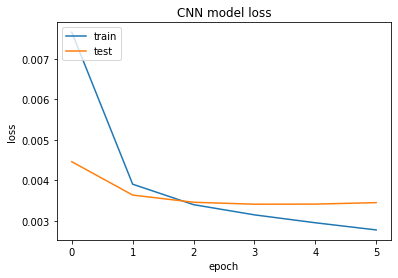

In [ ]:
#loss plotting.
epoch = []
train_loss = []
test_loss = []
for i in range(6):
  epoch.append(i+1)
  train_loss.append(list_result[i].history['loss'])
  test_loss.append(list_result[i].history['val_loss'])
plt.plot(train_loss)
plt.plot(test_loss)
plt.title('CNN model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
  


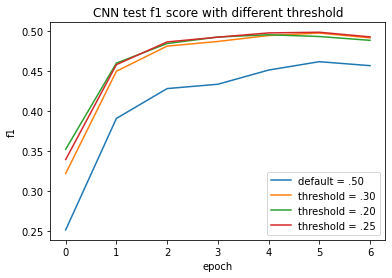

In [ ]:
#plotting f1 with different threshold
f1_point5= [list_result[i].history['val_get_f1'] for i in range(len(list_result))]
f1_point4 = [s[0] for s in history_test_f1]
f1_point2 =  [s[1] for s in history_test_f1]
f1_point25 =  [s[2] for s in history_test_f1]
plt.plot(f1_point5)
plt.plot(f1_point4)
plt.plot(f1_point2)
plt.plot(f1_point25)
plt.plot()
plt.title('CNN test f1 score with different threshold')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['default = .50','threshold = .30', 'threshold = .20','threshold = .25'], loc='lower right')
plt.show()




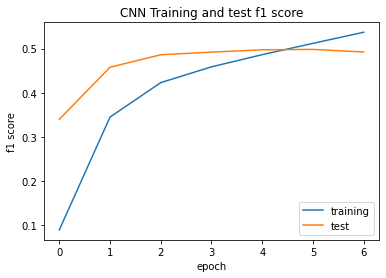

In [ ]:
#ploting training and testing f1 score(with best threshould)
traing_f1 = [list_result[i].history['get_f1'] for i in range(len(list_result))]
test_f1 =[s[2] for s in history_test_f1] # taking the result with best threshould
plt.plot(traing_f1)
plt.plot(test_f1)
plt.plot()
plt.title('CNN Training and test f1 score')
plt.ylabel('f1 score')
plt.xlabel('epoch')
plt.legend(['training','test'], loc='lower right')
plt.show()

In [ ]:

# best threshould is .25
#f1_point25  means f1 value in the test for threshold 0.25. use train each model and take too much time so we make a copy to further use.
# [0.3395633766372874,
#  0.4577541259200852,
#  0.4860496240605409,
#  0.49198682000354654,
#  0.49726505927944287,
#  0.4981098518738752,
#  0.4923363767959374]
# max f1 score is 0.4981098518738752

[0.3395633766372874,
 0.4577541259200852,
 0.4860496240605409,
 0.49198682000354654,
 0.49726505927944287,
 0.4981098518738752,
 0.4923363767959374]

# Model MLP

In [ ]:
def MLP():
    model = Sequential()
    model.add(Embedding(len(tokenizer.index_word)+1,300,input_length= 100)) #embedding dimension is 150 here
    model.add(Flatten())
    model.add(Dense(1024)) #1264
    model.add(Activation('relu'))
    model.add(Dense(3830))
    model.add(Activation('sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.001), metrics=[get_f1])
    model.summary()
    return model
model_MLP = MLP()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 300)          6079800   
                                                                 
 flatten_1 (Flatten)         (None, 30000)             0         
                                                                 
 dense_6 (Dense)             (None, 1024)              30721024  
                                                                 
 activation_6 (Activation)   (None, 1024)              0         
                                                                 
 dense_7 (Dense)             (None, 3830)              3925750   
                                                                 
 activation_7 (Activation)   (None, 3830)              0         
                                                                 
Total params: 40,726,574
Trainable params: 40,726,574


In [ ]:

best_model_his = 0
list_result = []
import copy
dataset_part = 0
max_f1 = -1
epoch = 3
history_test_f1 = []
history_test_precision =[]
history_test_recall = []
histry_loss =[]

df = pd.read_csv(path_econbiz,usecols=['title','labels'])

for i in range(1):
  dataset_part = dataset_part + 1

  train_x = df['title'].apply(preprocess_title)
  test_y = df['labels'].str.split()
  del df
  i = 0
  max_f1 = -1
  x_train = tokenizer.texts_to_sequences(train_x)
  x_train = pad_sequences(x_train, padding = 'post', maxlen = 100)
  y_train = mlb.transform(test_y)
  x_train,x_test, y_train, y_test = train_test_split(x_train,y_train,test_size=0.10,random_state = 42)

  while i < 9:
      best_model_his=model_MLP.fit(x_train,y_train,epochs=1,batch_size=128,verbose=1,validation_data=(x_test,y_test))
      list_result.append(best_model_his)
      preds = model_MLP.predict(x_test)
      preds2 = copy.deepcopy(preds)
      preds3 = copy.deepcopy(preds)
      preds[preds>=0.30] = 1
      preds[preds<0.30]= 0
      f1 = f1_score(y_test, preds, average="samples")
      max_f1 = max(max_f1,f1)
      preds2[preds2>=0.2] = 1
      preds2[preds2<0.2]= 0
      f11 = f1_score(y_test, preds2, average="samples")
      max_f1 = max(max_f1,f11)
      preds3[preds3>=0.25] = 1
      preds3[preds3<0.25]= 0
      f111 = f1_score(y_test, preds3, average="samples")
      max_f1 = max(max_f1,f111)
      history_test_f1.append([f1,f11,f111])
      del preds
      del preds2
      del preds3
      print(f'f1 score for 0.30 === {f1} and f1 score for 0.2 == {f11} and f1 for 0.25 {f111}')
      i = i +1
  del x_train
  del x_test
  del y_train
  del y_test
  print(f'dataset part {dataset_part}, value = {i+1} and max f1 score is {max_f1}')



1571/1571 [==============================] - 39s 25ms/step
f1 score for 0.30 === 0.32873993560901443 and f1 score for 0.2 == 0.3530924306537513 and f1 for 0.25 0.3434875578270464
1571/1571 [==============================] - 27s 17ms/step
f1 score for 0.30 === 0.42442227763008217 and f1 score for 0.2 == 0.4376025141388453 and f1 for 0.25 0.43464428811479977
1571/1571 [==============================] - 40s 25ms/step
f1 score for 0.30 === 0.45313621213764804 and f1 score for 0.2 == 0.46456275894737864 and f1 for 0.25 0.4622852105708689
1571/1571 [==============================] - 48s 30ms/step
f1 score for 0.30 === 0.4686642089995569 and f1 score for 0.2 == 0.4733092161555807 and f1 for 0.25 0.4735987803052846
1571/1571 [==============================] - 76s 48ms/step
f1 score for 0.30 === 0.47208482448774525 and f1 score for 0.2 == 0.4732483254402799 and f1 for 0.25 0.4755774992339301
1571/1571 [==============================] - 41s 26ms/step
f1 score for 0.30 === 0.46947365599049085 and

## Ploting MLP

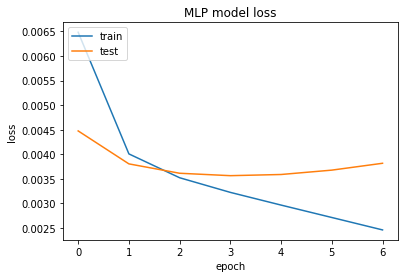

In [ ]:
#loss plotting.
epoch = []
train_loss = []
test_loss = []
for i in range(9):
  epoch.append(i+1)
  train_loss.append(list_result[i].history['loss'])
  test_loss.append(list_result[i].history['val_loss'])
plt.plot(train_loss[:7])
plt.plot(test_loss[:7])
plt.title('MLP model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

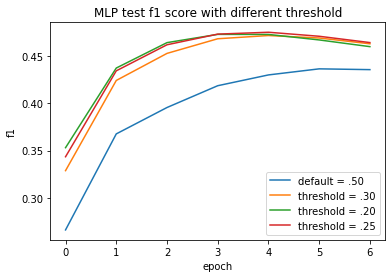

In [ ]:
#plotting f1 with different threshold
f1_point5= [list_result[i].history['val_get_f1'] for i in range(len(list_result))]
f1_point4 = [s[0] for s in history_test_f1]
f1_point2 =  [s[1] for s in history_test_f1]
f1_point25 =  [s[2] for s in history_test_f1]
plt.plot(f1_point5)
plt.plot(f1_point4)
plt.plot(f1_point2)
plt.plot(f1_point25)
plt.plot()
plt.title('MLP test f1 score with different threshold')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['default = .50','threshold = .30', 'threshold = .20','threshold = .25'], loc='lower right')
plt.show()

In [ ]:
# best threshould is .25
#f1_point25  means f1 value in the test for threshold 0.25. use train each model and take too much time so we make a copy to further use.
# [0.3434875578270464,
#  0.43464428811479977,
#  0.4622852105708689,
#  0.4735987803052846,
#  0.4755774992339301,
#  0.4713097259130036,
#  0.46460912554829903,
#  0.45382667371209495,
#  0.4453193959575987]
# max f1 score is 0.4755774992339301

[0.3434875578270464,
 0.43464428811479977,
 0.4622852105708689,
 0.4735987803052846,
 0.4755774992339301,
 0.4713097259130036,
 0.46460912554829903,
 0.45382667371209495,
 0.4453193959575987]

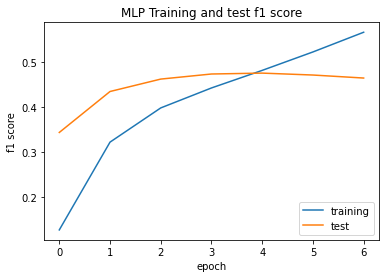

In [ ]:
#ploting training and testing f1 score(with best threshould)
traing_f1 = [list_result[i].history['get_f1'] for i in range(len(list_result))]
test_f1 =[s[2] for s in history_test_f1] # taking the result with best threshould
plt.plot(traing_f1)
plt.plot(test_f1)
plt.plot()
plt.title('MLP Training and test f1 score')
plt.ylabel('f1 score')
plt.xlabel('epoch')
plt.legend(['training','test'], loc='lower right')
plt.show()

#GRU Model

In [ ]:
from tensorflow.keras.layers import GRU
def GRU_model():
  model = Sequential()
  model.add(Embedding(len(tokenizer.index_word)+1,300,input_length= 100))
  model.add(Dropout(0.01))
  model.add(Bidirectional(GRU(64))) #64
  model.add(Dense(600))
  model.add(Dropout(0.01)) 
  model.add(Activation('relu'))
  model.add(Dense(3830))
  model.add(Activation('sigmoid'))
  model.compile(loss='binary_crossentropy',optimizer='adam',metrics=[get_f1])
  model.summary()
  return model

model_GRU = GRU_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 300)          6079800   
                                                                 
 dropout (Dropout)           (None, 100, 300)          0         
                                                                 
 bidirectional (Bidirectiona  (None, 128)              140544    
 l)                                                              
                                                                 
 dense (Dense)               (None, 600)               77400     
                                                                 
 dropout_1 (Dropout)         (None, 600)               0         
                                                                 
 activation (Activation)     (None, 600)               0         
                                                        

In [ ]:
best_model_his = 0
list_result = []
import copy
dataset_part = 0
max_f1 = -1
epoch = 3
history_test_f1 = []
histry_loss =[]

df = pd.read_csv(path_econbiz,usecols=['title','labels'])

for i in range(1):
  dataset_part = dataset_part + 1
  train_x = df['title'].apply(preprocess_title)
  test_y = df['labels'].str.split()
  del df
  i = 0
  max_f1 = -1
  x_train = tokenizer.texts_to_sequences(train_x)
  x_train = pad_sequences(x_train, padding = 'post', maxlen = 100)
  y_train = mlb.transform(test_y)
  x_train,x_test, y_train, y_test = train_test_split(x_train,y_train,test_size=0.10,random_state = 42)

  while i < 12:
      best_model_his=model_GRU.fit(x_train,y_train,epochs=1,batch_size=128,verbose=1,validation_data=(x_test,y_test))
      list_result.append(best_model_his)
      preds = model_GRU.predict(x_test)
      preds2 = copy.deepcopy(preds)
      preds3 = copy.deepcopy(preds)
      preds[preds>=0.30] = 1
      preds[preds<0.30]= 0
      f1 = f1_score(y_test, preds, average="samples")
      max_f1 = max(max_f1,f1)
      preds2[preds2>=0.2] = 1
      preds2[preds2<0.2]= 0
      f11 = f1_score(y_test, preds2, average="samples")
      max_f1 = max(max_f1,f11)
      preds3[preds3>=0.25] = 1
      preds3[preds3<0.25]= 0
      f111 = f1_score(y_test, preds3, average="samples")
      max_f1 = max(max_f1,f111)
      history_test_f1.append([f1,f11,f111])
      del preds
      del preds2
      del preds3
      print(f'f1 score for 0.30 === {f1} and f1 score for 0.2 == {f11} and f1 for 0.25 {f111}')
      i = i +1
  del x_train
  del x_test
  del y_train
  del y_test
  print(f'dataset part {dataset_part}, value = {i+1} and max f1 score is {max_f1}')

1571/1571 [==============================] - 150s 95ms/step
f1 score for 0.30 === 0.1578315959761376 and f1 score for 0.2 == 0.20046294253814892 and f1 for 0.25 0.17840925327902196
1571/1571 [==============================] - 163s 104ms/step
f1 score for 0.30 === 0.3685772205770043 and f1 score for 0.2 == 0.3950089059392549 and f1 for 0.25 0.3848906173218248
1571/1571 [==============================] - 171s 109ms/step
f1 score for 0.30 === 0.43497096854965656 and f1 score for 0.2 == 0.4497602867856647 and f1 for 0.25 0.44595213553471785
1571/1571 [==============================] - 174s 111ms/step
f1 score for 0.30 === 0.45497589546658246 and f1 score for 0.2 == 0.4690441551193938 and f1 for 0.25 0.4656883377764914
1571/1571 [==============================] - 180s 115ms/step
f1 score for 0.30 === 0.4710855996753316 and f1 score for 0.2 == 0.47837604830861014 and f1 for 0.25 0.47809014229315155
1571/1571 [==============================] - 168s 107ms/step
f1 score for 0.30 === 0.478035097

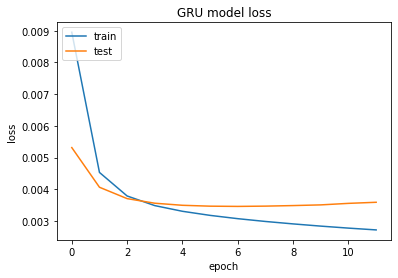

In [ ]:
#loss plotting.
epoch = []
train_loss = []
test_loss = []
for i in range(12):
  epoch.append(i+1)
  train_loss.append(list_result[i].history['loss'])
  test_loss.append(list_result[i].history['val_loss'])
plt.plot(train_loss)
plt.plot(test_loss)
plt.title('GRU model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

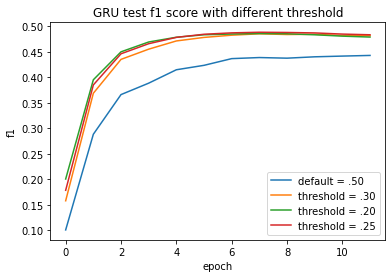

In [ ]:
f1_point5= [list_result[i].history['val_get_f1'] for i in range(len(list_result))]
f1_point4 = [s[0] for s in history_test_f1]
f1_point2 =  [s[1] for s in history_test_f1]
f1_point25 =  [s[2] for s in history_test_f1]
plt.plot(f1_point5)
plt.plot(f1_point4)
plt.plot(f1_point2)
plt.plot(f1_point25)
plt.plot()
plt.title('GRU test f1 score with different threshold')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['default = .50','threshold = .30', 'threshold = .20','threshold = .25'], loc='lower right')
plt.show()

In [ ]:
f1_point25
# best threshould is .25
#f1_point25  means f1 value in the test for threshold 0.25. use train each model and take too much time so we make a copy to further use.
# [0.17840925327902196,
#  0.3848906173218248,
#  0.44595213553471785,
#  0.4656883377764914,
#  0.47809014229315155,
#  0.4842187043022346,
#  0.4869398963558118,
#  0.48815975121997646,
#  0.4877093819297985,
#  0.4868254923567659,
#  0.48454945545491035,
#  0.4832035983686113]
# max f1 score is 0.48815975121997646

[0.17840925327902196,
 0.3848906173218248,
 0.44595213553471785,
 0.4656883377764914,
 0.47809014229315155,
 0.4842187043022346,
 0.4869398963558118,
 0.48815975121997646,
 0.4877093819297985,
 0.4868254923567659,
 0.48454945545491035,
 0.4832035983686113]

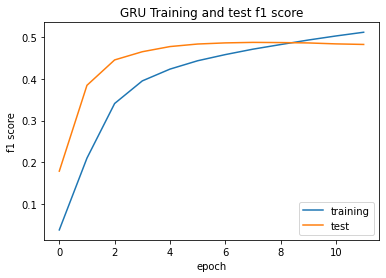

In [ ]:
#ploting training and testing f1 score(with best threshould)
traing_f1 = [list_result[i].history['get_f1'] for i in range(len(list_result))]
test_f1 =[s[2] for s in history_test_f1] # taking the result with best threshould
plt.plot(traing_f1)
plt.plot(test_f1)
plt.plot()
plt.title('GRU Training and test f1 score')
plt.ylabel('f1 score')
plt.xlabel('epoch')
plt.legend(['training','test'], loc='lower right')
plt.show()

# LSTM Model

In [ ]:
from tensorflow.keras.layers import LSTM
def LSTM_model():
  model = Sequential()
  model.add(Embedding(len(tokenizer.index_word)+1,300,input_length= 100))
  model.add(Dropout(0.01))
  model.add(Bidirectional(LSTM(64))) #64
  model.add(Dense(600))
  model.add(Dropout(0.01)) 
  model.add(Activation('relu'))
  model.add(Dense(3830))
  model.add(Activation('sigmoid'))
  model.compile(loss='binary_crossentropy',optimizer='adam',metrics=[get_f1])
  model.summary()
  return model

model_LSTM = LSTM_model()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 100, 300)          6079800   
                                                                 
 dropout_1 (Dropout)         (None, 100, 300)          0         
                                                                 
 bidirectional (Bidirectiona  (None, 128)              186880    
 l)                                                              
                                                                 
 dense_8 (Dense)             (None, 600)               77400     
                                                                 
 dropout_2 (Dropout)         (None, 600)               0         
                                                                 
 activation_8 (Activation)   (None, 600)               0         
                                                      

In [ ]:
best_model_his = 0
list_result = []
import copy
dataset_part = 0
max_f1 = -1
epoch = 3
history_test_f1 = []
histry_loss =[]
# data_chunk = pd.read_csv(path_econbiz,chunksize=167551,usecols=['title','labels'])
df = pd.read_csv(path_econbiz,usecols=['title','labels'])

for i in range(1):
  dataset_part = dataset_part + 1
  train_x = df['title'].apply(preprocess_title)
  test_y = df['labels'].str.split()
  del df
  i = 0
  max_f1 = -1
  x_train = tokenizer.texts_to_sequences(train_x)
  x_train = pad_sequences(x_train, padding = 'post', maxlen = 100)
  y_train = mlb.transform(test_y)
  x_train,x_test, y_train, y_test = train_test_split(x_train,y_train,test_size=0.10,random_state = 42)

  while i < 12:
      best_model_his=model_LSTM.fit(x_train,y_train,epochs=1,batch_size=128,verbose=1,validation_data=(x_test,y_test))
      list_result.append(best_model_his)
      preds = model_LSTM.predict(x_test)
      preds2 = copy.deepcopy(preds)
      preds3 = copy.deepcopy(preds)
      preds[preds>=0.30] = 1
      preds[preds<0.30]= 0
      f1 = f1_score(y_test, preds, average="samples")
      max_f1 = max(max_f1,f1)
      preds2[preds2>=0.2] = 1
      preds2[preds2<0.2]= 0
      f11 = f1_score(y_test, preds2, average="samples")
      max_f1 = max(max_f1,f11)
      preds3[preds3>=0.25] = 1
      preds3[preds3<0.25]= 0
      f111 = f1_score(y_test, preds3, average="samples")
      max_f1 = max(max_f1,f111)
      history_test_f1.append([f1,f11,f111])
      del preds
      del preds2
      del preds3
      print(f'f1 score for 0.30 === {f1} and f1 score for 0.2 == {f11} and f1 for 0.25 {f111}')
      i = i +1
  del x_train
  del x_test
  del y_train
  del y_test
  print(f'dataset part {dataset_part}, value = {i+1} and max f1 score is {max_f1}')

1571/1571 [==============================] - 192s 122ms/step
f1 score for 0.30 === 0.08033793282751181 and f1 score for 0.2 == 0.11476449710892475 and f1 for 0.25 0.09939882618862798
1571/1571 [==============================] - 190s 121ms/step
f1 score for 0.30 === 0.26751966567566304 and f1 score for 0.2 == 0.30556239865124646 and f1 for 0.25 0.2883086795031518
1571/1571 [==============================] - 207s 132ms/step
f1 score for 0.30 === 0.39317872741308746 and f1 score for 0.2 == 0.41332837570709496 and f1 for 0.25 0.40676217020866046
1571/1571 [==============================] - 198s 126ms/step
f1 score for 0.30 === 0.43514073038143375 and f1 score for 0.2 == 0.4490560911124742 and f1 for 0.25 0.44571897495191243
1571/1571 [==============================] - 187s 119ms/step
f1 score for 0.30 === 0.4563553152304217 and f1 score for 0.2 == 0.4667320707999839 and f1 for 0.25 0.46505950545173497
1571/1571 [==============================] - 176s 112ms/step
f1 score for 0.30 === 0.4656

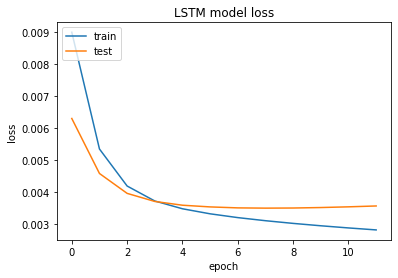

In [ ]:
#loss plotting.
epoch = []
train_loss = []
test_loss = []
for i in range(12):
  epoch.append(i+1)
  train_loss.append(list_result[i].history['loss'])
  test_loss.append(list_result[i].history['val_loss'])
plt.plot(train_loss)
plt.plot(test_loss)
plt.title('LSTM model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

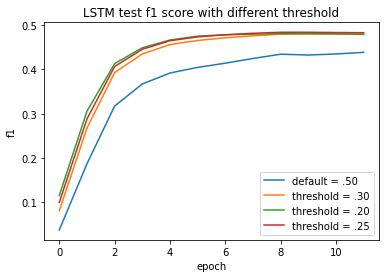

In [ ]:
f1_point5= [list_result[i].history['val_get_f1'] for i in range(len(list_result))]
f1_point4 = [s[0] for s in history_test_f1]
f1_point2 =  [s[1] for s in history_test_f1]
f1_point25 =  [s[2] for s in history_test_f1]
plt.plot(f1_point5)
plt.plot(f1_point4)
plt.plot(f1_point2)
plt.plot(f1_point25)
plt.plot()
plt.title('LSTM test f1 score with different threshold')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['default = .50','threshold = .30', 'threshold = .20','threshold = .25'], loc='lower right')
plt.show()

In [ ]:
f1_point25
# best threshould is .25
#f1_point25  means f1 value in the test for threshold 0.25. use train each model and take too much time so we make a copy to further use.
[0.09939882618862798,
 0.2883086795031518,
 0.40676217020866046,
 0.44571897495191243,
 0.46505950545173497,
 0.4737860518356896,
 0.4785761329376141,
 0.4819404084156997,
 0.4842786587426964,
 0.48423148085725026,
 0.4836926210110083,
 0.4832462287849158]
# max f1 score is 0.48423148085725026

[0.09939882618862798,
 0.2883086795031518,
 0.40676217020866046,
 0.44571897495191243,
 0.46505950545173497,
 0.4737860518356896,
 0.4785761329376141,
 0.4819404084156997,
 0.4842786587426964,
 0.48423148085725026,
 0.4836926210110083,
 0.4832462287849158]

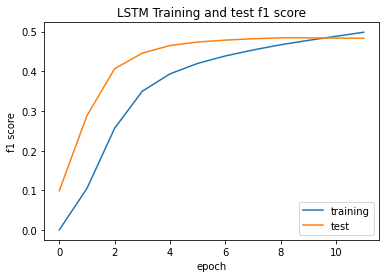

In [ ]:
#ploting training and testing f1 score(with best threshould)
traing_f1 = [list_result[i].history['get_f1'] for i in range(len(list_result))]
test_f1 =[s[2] for s in history_test_f1] # taking the result with best threshould
plt.plot(traing_f1)
plt.plot(test_f1)
plt.plot()
plt.title('LSTM Training and test f1 score')
plt.ylabel('f1 score')
plt.xlabel('epoch')
plt.legend(['training','test'], loc='lower right')
plt.show()

# Result Compare Graph


In [ ]:
# all model f1 score with different epoch
# bargraph for all model max f1

In [ ]:
# giving the manual input that I saved while testing for 8 for cnn and 9 for other all after that overfitting the model
f1_CNN_with_epochs = [0.3395633766372874, 0.4577541259200852, 0.4860496240605409, 0.49198682000354654, 0.49726505927944287, 0.4981098518738752, 0.4923363767959374]
f1_MLP_with_epochs = [0.3434875578270464, 0.43464428811479977, 0.4622852105708689, 0.4735987803052846, 0.4755774992339301, 0.4713097259130036, 0.46460912554829903,0.45382667371209495,0.4453193959575987]
f1_GRU_with_epochs = [0.17840925327902196, 0.3848906173218248, 0.44595213553471785, 0.4656883377764914, 0.47809014229315155, 0.4842187043022346, 0.4869398963558118, 0.48815975121997646, 0.4877093819297985]
f1_LSTM_with_epochs = [0.09939882618862798, 0.2883086795031518, 0.40676217020866046, 0.44571897495191243, 0.46505950545173497, 0.4737860518356896, 0.4785761329376141, 0.4819404084156997, 0.4842786587426964]


In [ ]:
f1_max_cnn = max(f1_CNN_with_epochs)
f1_max_MLP = max(f1_MLP_with_epochs)
f1_max_GRU = max(f1_GRU_with_epochs)
f1_max_LSTM = max(f1_LSTM_with_epochs)

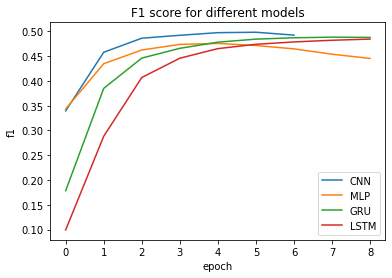

In [ ]:
plt.plot(f1_CNN_with_epochs)
plt.plot(f1_MLP_with_epochs)
plt.plot(f1_GRU_with_epochs)
plt.plot(f1_LSTM_with_epochs)
plt.plot()
plt.title('F1 score for different models')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['CNN','MLP', 'GRU','LSTM'], loc='lower right')
plt.show()

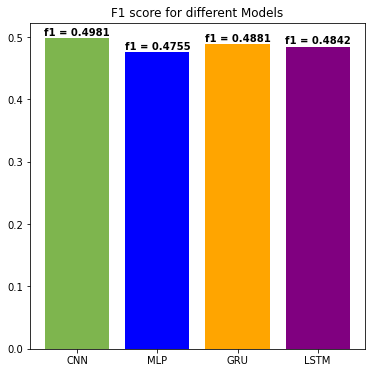

In [ ]:
# depict illustration
plt.figure(figsize=(6,6))
colors_list = ['#7eb54e','Blue', 'Orange', 'Purple']
list_name = ['CNN','MLP','GRU','LSTM']
list_result = [f1_max_cnn,f1_max_MLP,f1_max_GRU,f1_max_LSTM]
graph = plt.bar(list_name,list_result, color = colors_list)
plt.title('F1 score for different Models')
 
i = 0
for p in graph:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    plt.text(x+width/2,
             y+height*1.01,
             'f1 = '+ str(int(list_result[i]*10000)/10000),
             ha='center',
             weight='bold')
    i+=1
plt.show()

**CNN gives the best result which is 0.4755**